In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BT_Plus/Chapter_4'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BT_Plus/Chapter_4


In [ ]:
!pip install pandas-profiling==2.7.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pandas_profiling as pp
%matplotlib inline
from sklearn.datasets import fetch_openml

In [3]:
data = fetch_openml(data_id=1220)

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'], name='click').astype('int')

df = pd.concat([X, y], axis=1)
df

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id,click
0,1.0,8343295.0,11700.0,3.0,3.0,21264.0,27892.0,1559.0,0.0,0
1,1.0,20017077.0,23798.0,1.0,1.0,35498.0,4.0,36476.0,562934.0,1
2,1.0,21348354.0,36654.0,1.0,1.0,19975.0,36105.0,33292.0,11621116.0,0
3,1.0,20366086.0,33280.0,3.0,3.0,5942.0,4057.0,4390.0,8778348.0,0
4,1.0,6803526.0,10790.0,2.0,1.0,60593.0,25242.0,1679.0,12118311.0,0
...,...,...,...,...,...,...,...,...,...,...
39943,1.0,21898643.0,37867.0,2.0,1.0,1091.0,1657.0,1914.0,0.0,0
39944,1.0,20575578.0,8873.0,2.0,1.0,8338.0,7866.0,9210.0,19487.0,0
39945,5.0,21183848.0,18716.0,2.0,1.0,9594.0,8881.0,13277.0,2305.0,0
39946,1.0,21222438.0,35880.0,3.0,3.0,13078.0,943122.0,1436.0,0.0,0


In [ ]:
profile = pp.ProfileReport(df)
profile

Output hidden; open in https://colab.research.google.com to view.

In [4]:
df.corr()

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id,click
impression,1.000000,-0.008946,0.000056,0.006966,0.005456,-0.003067,-0.003515,-0.003542,-0.009740,0.023876
ad_id,-0.008946,1.000000,0.329384,0.055689,0.035880,0.010548,0.056440,0.043192,-0.011958,-0.015202
advertiser_id,0.000056,0.329384,1.000000,0.034990,0.022872,-0.058575,-0.001850,-0.005917,0.025834,-0.027146
depth,0.006966,0.055689,0.034990,1.000000,0.548731,0.014689,0.092812,0.079156,-0.258668,-0.053392
position,0.005456,0.035880,0.022872,0.548731,1.000000,-0.000391,0.055589,0.050941,-0.154612,-0.123688
keyword_id,-0.003067,0.010548,-0.058575,0.014689,-0.000391,1.000000,0.703213,0.604124,-0.092058,0.027127
title_id,-0.003515,0.056440,-0.001850,0.092812,0.055589,0.703213,1.000000,0.803911,-0.120390,0.012609
description_id,-0.003542,0.043192,-0.005917,0.079156,0.050941,0.604124,0.803911,1.000000,-0.107920,0.004623
user_id,-0.009740,-0.011958,0.025834,-0.258668,-0.154612,-0.092058,-0.120390,-0.107920,1.000000,0.078729
click,0.023876,-0.015202,-0.027146,-0.053392,-0.123688,0.027127,0.012609,0.004623,0.078729,1.000000


In [ ]:
# df.drop(columns=['ad_id', 'title_id', 'description_id'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
categoric = ['depth', 'position']
numeric = ['impression']
objective = ['advertiser_id', 'keyword_id', 'user_id', 'ad_id', 'title_id', 'description_id']
target = 'click'

In [5]:
df = df.drop_duplicates()
df.shape

(39782, 10)

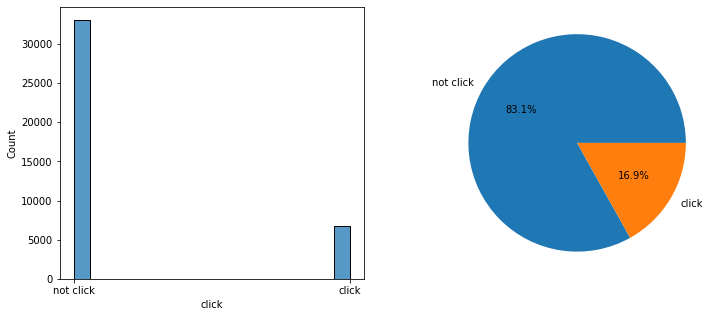

In [6]:
labels = ['not click', 'click']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sb.histplot(df[target])
plt.xticks([0, 1], labels)

plt.subplot(1,2,2)
plt.pie(df[target].value_counts().sort_index(), labels=labels, autopct='%1.1f%%')
plt.show()

- Dữ liệu bị Imbalanced rất lớn, nên cần target AUC thay vì accuracy.
- Đồng thời có thể kết hợp thực hiện các kỹ thuật over_sampling hay under_sampling để cải thiện kết quả.
- So sánh độ hiệu quả giữa các model thông qua chart ROC và giá trị AUC.

In [7]:
# Viết function pre-processing
def pre_processing(data, numeric_col=numeric, categoric_col=categoric, objective_col=objective, target_col=target, one_hot=True):
    df_num = data[numeric_col]
    # One-hot
    if one_hot:
        df_cate = pd.get_dummies(data[categoric_col], columns=categoric_col, drop_first=True)
    else:
        df_cate = data[categoric_col]
    df_object = data[objective_col]
    df_target = data[[target_col]]
    df = pd.concat([df_num, df_cate, df_object, df_target], axis=1)

    # Split train-test
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    # Sử dụng Robust Scaler
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    X_train[numeric] = scaler.fit_transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = pre_processing(df)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold

list_model = [
            #   ('Linear Regression', LogisticRegression()),
              ('Naive Bayes', GaussianNB()),
            #   ('KNN (3)', KNeighborsClassifier(3)),
            #   ('KNN (5)', KNeighborsClassifier(5)),
            #   ('KNN (8)', KNeighborsClassifier(8)),
            #   ('SVC - linear', SVC(kernel='linear')),
            #   ('SVC - poly 2', SVC(kernel='poly', degree=2)),
            #   ('SVC - poly 3', SVC(kernel='poly', degree=3)),
              ('SVC - rbf', SVC(kernel='rbf')),
              ('Random Forest', RandomForestClassifier(random_state=42)),
            #   ('AdaBoost', AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)),
            #   ('XGBoost', XGBRegressor()),
]

In [12]:
def result_model_cv(list_model, X_train, X_test, y_train, y_test, cv_k=5, show_table=False):
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import cross_validate, KFold
    from sklearn.metrics import accuracy_score, roc_auc_score

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    result = []
    for name, model in list_model:
        cv_result = cross_validate(model, X_train, y_train, cv=kfold, return_train_score=True, scoring=['accuracy', 'roc_auc'])
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Get FPR, TPR for ROC chart + AUC
        try:
            y_proba_train = model.fit(X_train, y_train).decision_function(X_train)
            y_proba_test = model.fit(X_train, y_train).decision_function(X_test)
        except Exception:
            y_proba_train = model.fit(X_train, y_train).predict_proba(X_train)[:, 1]
            y_proba_test = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
        result.append([name, 
                       cv_result['train_accuracy'].mean(),
                       cv_result['test_accuracy'].mean(),
                       cv_result['train_roc_auc'].mean(),
                       cv_result['test_roc_auc'].mean(),
                    #    cv_result['fit_time'].mean(),
                    #    cv_result['score_time'].mean(),
                       accuracy_score(y_train, y_pred_train),
                       accuracy_score(y_test, y_pred_test),
                       roc_auc_score(y_train, y_proba_train),
                       roc_auc_score(y_test, y_proba_test),
        ])

    result = pd.DataFrame(result, columns=['model', 'train_cv_accuracy', 'test_cv_accuracy',  
                                           'train_cv_auc', 'test_cv_auc', 
                                        #    'fit_time', 'score_time',
                                           'train_accuracy', 'test_accuracy', 'train_auc', 'test_auc',
                                           ])
    result.sort_values('test_cv_auc', ascending=True, inplace=True)
    if show_table:
        display(result)
    return result

In [13]:
result_model_cv(list_model, X_train, X_test, y_train, y_test)

,model,train_cv_accuracy,test_cv_accuracy,train_cv_auc,test_cv_auc,train_accuracy,test_accuracy,train_auc,test_auc
1,SVC - rbf,0.831780,0.831780,0.513345,0.516430,0.831780,0.828976,0.535549,0.518890
0,Naive Bayes,0.811268,0.811637,0.556927,0.556522,0.810933,0.809974,0.556563,0.543590
2,Random Forest,0.999548,0.826049,0.999999,0.665712,0.999430,0.821637,0.999998,0.656834


- Có thể thấy được model Random Forest (default hyper-parameter) có AUC tốt nhất.
- Sử dụng Grid để tunning hyper-parameter cho Random Forest.
- Đồng thời sử dụng thêm AdaBoost, XGBoost xem có cải thiện thêm được AUC không.

In [11]:
model_tunning_list = [
              ('Random Forest', RandomForestClassifier(random_state=42)),
              ('AdaBoost', AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)),
              ('XGBoost', XGBClassifier(random_state=42)),
]

param_grid_rdn_forest = {'n_estimators': [100, 200],
              'criterion': ['gini', 'entropy'],
              'max_features': [2, 4, 5, 'sqrt'],
            }

param_grid_ada_boost = {'n_estimators': [50, 100, 150],
              'learning_rate': [0.001, 0.005, 0.01, 0.1],
            }

param_grid_xg_boost = {'n_estimators': [100, 500],
              'learning_rate': [0.001, 0.005, 0.01, 0.1],
            }

params = [
          param_grid_rdn_forest,
          param_grid_ada_boost,
          param_grid_xg_boost,
]

In [12]:
# Viết function tuning hyper-parameters models bằng Grid
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

def process_tunning_model(model_tunning_list, params, X, y, scoring='roc_auc', cv_k=5):
    from sklearn.model_selection import GridSearchCV, KFold
    import time
    models_final = []
    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)

    for model_list, param in zip(model_tunning_list, params):
        tic = time.time()
        model_name, model = model_list
        search = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} have been tunned in {:,.2f} seconds'.format(model_name, (toc-tic)))
    return models_final

In [ ]:
models_final = process_tunning_model(model_tunning_list, params, X_train, y_train)
models_final

Model Random Forest have been tunned in 1,137.14 seconds


In [ ]:
result_model_cv(models_final, X_train, X_test, y_train, y_test)

In [ ]:
def process_get_metrics_values(model, X_train, y_train, X_test, y_test, rebalance_method=None):
    from sklearn.metrics import roc_auc_score, roc_curve, auc, balanced_accuracy_score, \
                                accuracy_score, precision_score, recall_score, f1_score, \
                                precision_recall_curve, average_precision_score

    if rebalance_method != None:
        X_train, y_train = rebalance_method[0].fit_resample(X_train, y_train)

    mean_fpr = np.linspace(0, 1, 20)
    mean_recall_draw = np.linspace(1, 0, 20)
    # Get FPR, TPR for ROC chart + AUC
    try:
        y_proba = model.fit(X_train, y_train).decision_function(X_test)
    except Exception:
        y_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, drop_intermediate=False)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0
    interp_tpr[-1] = 1

    # Get precision_draw, recall_draw due to changes in thresholds
    preci_draw, recall_draw, thres = precision_recall_curve(y_test, y_proba)
    preci_draw[-1] = 1
    interp_preci = np.interp(mean_recall_draw, recall_draw, preci_draw, period=1)
    interp_preci[-1] = 1
    interp_preci[0] = 0
    no_skill = len(y_test[y_test==1]) / len(y_test)
    avg_preci_score = average_precision_score(y_test, y_proba)

    # Get other metrics: accuracy, balanced_accuracy, precision, recall, f1
    y_pred = model.predict(X_test)

    return {'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'fpr': mean_fpr,
            'tpr': interp_tpr,
            'recall_draw': mean_recall_draw,
            'preci_draw': interp_preci,
            'no_skill': no_skill,
            'avg_preci': avg_preci_score 
            }

In [ ]:
def plot_cv_roc(result, name_model):
    from sklearn.metrics import auc
    mean_fpr = result['fpr']
    mean_tpr = result['tpr']
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, lw=(mean_auc-0.5)*10, label=name_model+', auc = {:.2f}'.format(mean_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('ROC chart')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

def plot_cv_precision_recall(result, name_model):
    mean_recall = result['recall_draw']
    mean_precision = result['preci_draw']
    mean_precision[0] = mean_precision[1]
    no_skill = result['no_skill']
    avg_preci = result['avg_preci']
    plt.step(mean_recall, mean_precision, where='post', lw=(avg_preci-0.2)*10, label=name_model+', avg = {:.2f}'.format(avg_preci))
    plt.plot([0, 1], [no_skill, no_skill], 'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('Precision-Recall chart')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

def plot_roc_chart_multiple_models(models_list, X_train, y_train, X_test, y_test, rebalance_method=None):
    plt.figure(figsize=(20,10))
    score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    for name_model, model in models_list:
        result_model = process_get_metrics_values(model, X_train, y_train, X_test, y_test, rebalance_method=rebalance_method)
        plt.subplot(1,2,1)
        plot_cv_roc(result_model, name_model)
        plt.subplot(1,2,2)
        plot_cv_precision_recall(result_model, name_model)
        # result_model.pop('fpr')
        # result_model.pop('tpr')
        score_table.loc[name_model] = result_model
    if rebalance_method != None:
        plt.title('ROC chart on Resample method: '+ rebalance_method[1])
    plt.show()
    display(score_table.sort_values(by='f1', ascending=False))

In [ ]:
plot_roc_chart_multiple_models(models_final, X_train, y_train, X_test, y_test)